# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from consav.misc import elapsed
from FullHANKSAMModel import FullHANKSAMModelClass
from figures import create_fig, save_fig

# Setup

In [2]:
model = FullHANKSAMModelClass(name='baseline')
model.load_parameters('calibration')
model.load_data()

In [3]:
par = model.par
ss = model.ss

# Solve

In [4]:
model.find_ss()
model.compute_jacs(skip_shocks=True)
model.find_transition_path()

# Convergence to exogenous separations

In [5]:
models = []
labels = []
for psi in [0.0,0.001,0.01,0.1]:
    
    print(f'{psi = }')
    
    model_ = model.copy()
    model_.par.psi = psi
    if np.isclose(psi,0.0): model_.par.exo_sep = True
       
    model_.find_ss()
    model_.compute_jacs(skip_shocks=True)
    model_.find_transition_path()
    
    models.append(model_)
    if model_.par.exo_sep:
        labels.append(f'$\psi = {psi}$ (exo. sep.)')
    else:
        labels.append(f'$\psi = {psi}$')    


psi = 0.0
psi = 0.001
psi = 0.01
psi = 0.1


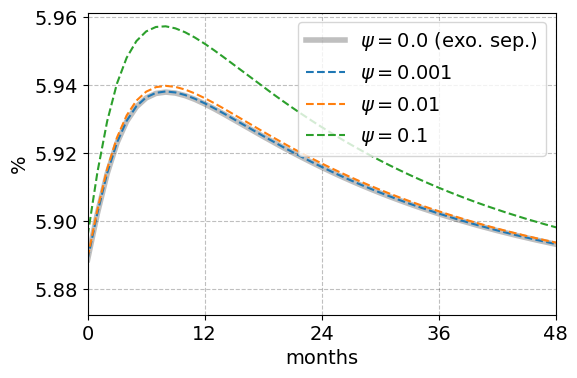

In [6]:
fig,ax = create_fig()

for model_,label in zip(models,labels):
    if model_.par.exo_sep == False:
        ax.plot(model_.path.u[0,:]*100,label=label,ls='--')
    else:
        ax.plot(model_.path.u[0,:]*100,label=label,color='black',lw=4,alpha=0.25)

save_fig(fig,ax,
         filename='convergence_psi_u',
         ylabel='%',legend=True)

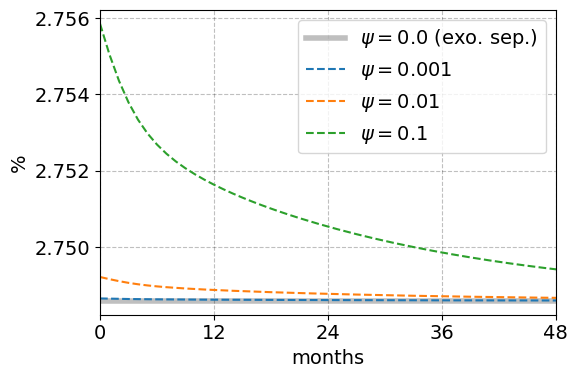

In [7]:
fig,ax = create_fig()

for model_,label in zip(models,labels):
    if model_.par.exo_sep == False:
        ax.plot(model_.path.delta[0,:]*100,label=label,ls='--')
    else:
        ax.plot(model_.path.delta[0,:]*100,label=label,color='black',lw=4,alpha=0.25)
            
save_fig(fig,ax,
         filename='convergence_psi_delta',
         ylabel='%',legend=True)

# Convergence to free entry

In [8]:
models = []
labels = []
for xi in [np.inf,5.0,1.0,0.1]:
    
    print(f'{xi = }')
    
    model_ = model.copy()
    model_.par.xi = xi
    if np.isinf(xi): model_.set_macros(free_entry=True)
       
    model_.find_ss()
    model_.compute_jacs(skip_shocks=True)
    model_.find_transition_path()
    
    models.append(model_)
    if model_.par.free_entry:
        labels.append(f'free entry')
    else:
        labels.append(f'$\\xi = {xi}$')


xi = inf
xi = 5.0
xi = 1.0
xi = 0.1


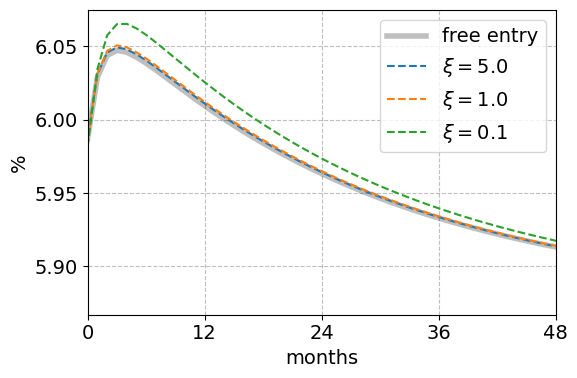

In [9]:
fig,ax = create_fig()

for model_,label in zip(models,labels):
    if model_.par.free_entry == False:
        ax.plot(model_.path.u[0,:]*100,label=label,ls='--')
    else:
        ax.plot(model_.path.u[0,:]*100,label=label,color='black',lw=4,alpha=0.25)

save_fig(fig,ax,
         filename='convergence_xi_u',
         ylabel='%',legend=True)

# Varying $\psi$ and $\xi$

In [10]:
psi_vec = np.sort(np.unique([0.0,0.5,1.0,1.5] + [model.par.psi]))
xi_vec = np.sort(np.unique([0.03,0.04,0.05,100.0] + [model.par.xi]))

models_psi_xi = {}
for i,psi in enumerate(psi_vec):
    for j,xi in enumerate(xi_vec):

        model_ = model.copy()

        t0 = time.time()
        print(f'{psi = }, {xi = }',end='')

        # xi
        model_.par.xi = xi                            
        if np.isinf(xi): model_.set_macros(free_entry=True)

        # psi
        model_.par.psi = psi
        if psi == 0.0: model_.par.exo_sep = True

        try:

            model_.find_ss()
            model_.compute_jacs()
            model_.find_transition_path()
            model_.calc_calib_moms()
            
            models_psi_xi[(psi,xi)] = model_.copy()
            print('')
            
        except Exception as e:
            
            print(f' - {e}')
            
            

psi = 0.0, xi = 0.02
psi = 0.0, xi = 0.03
psi = 0.0, xi = 0.04
psi = 0.0, xi = 0.05
psi = 0.0, xi = 100.0
psi = 0.5, xi = 0.02
psi = 0.5, xi = 0.03
psi = 0.5, xi = 0.04
psi = 0.5, xi = 0.05
psi = 0.5, xi = 100.0
psi = 1.0, xi = 0.02
psi = 1.0, xi = 0.03
psi = 1.0, xi = 0.04
psi = 1.0, xi = 0.05
psi = 1.0, xi = 100.0
psi = 1.5, xi = 0.02
psi = 1.5, xi = 0.03
psi = 1.5, xi = 0.04
psi = 1.5, xi = 0.05
psi = 1.5, xi = 100.0


In [11]:
def plot(basemodel,models,psi_vec,xi_vec,postfix=''):
        
    for (momname,ylabel) in [
        ('var_u','%-points'),
        ('EU_share','%'),        
        ('timeshift','months'),        
        #('C_drop_ss','%'),
    ]:

        print(f'###  {momname} ###')
        
        fig,ax = create_fig()

        for j,xi in enumerate(xi_vec):

            x = [psi for psi in psi_vec if (psi,xi) in models]
            models_ = [models[(psi,xi)] for psi in psi_vec if (psi,xi) in models]

            if len(models_) == 0: continue
            
            y = [model_.moms[momname] for model_ in models_]

            label = fr'$\xi = {xi:.3f}$' if not np.isinf(xi) else 'free entry'

            if xi == basemodel.par.xi:
                ax.axvline(basemodel.par.psi,color='black',ls='--',zorder=0)
                basey = [model_.moms[momname] for model_ in models_ if model_.par.psi == basemodel.par.psi][0]
                    
                if momname in ['timeshift','EU_share']:
                    ax.axhline(basey,color='black',ls='--',zorder=0)    
                ax.plot(x,y,'--o',color='black',lw=2,label=label)
            elif np.isinf(xi):
                ax.plot(x,y,'--o',zorder=0,color='black',lw=2,label=label)
            else:
                ax.plot(x,y,'-o',lw=2,label=label)

            if momname == 'var_u': ax.legend(frameon=True)
            if momname == 'EU_share': ax.legend(frameon=True)
            
            ax.set_xlabel('$\psi$')
            ax.set_ylabel(ylabel)
        
        if momname == 'C_drop_ss':
            ax.set_ylim([basemodel.par.C_drop_ss_target-1,basemodel.par.C_drop_ss_target+1])
                        
        fig.tight_layout()
        fig.savefig(f'results/{momname}{postfix}.pdf')

        plt.show()


###  var_u ###


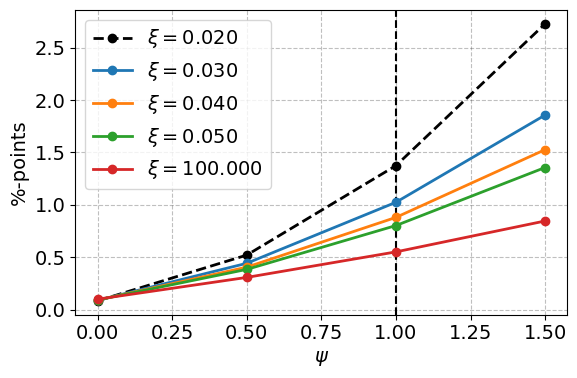

###  EU_share ###


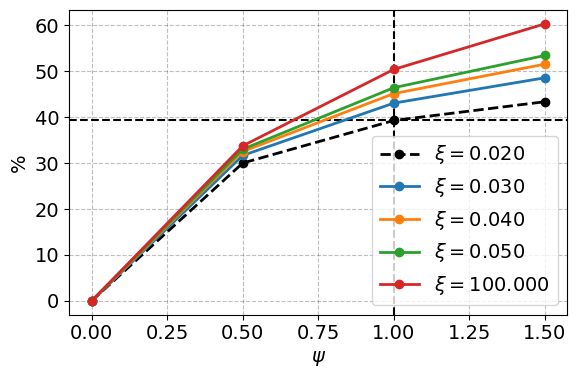

###  timeshift ###


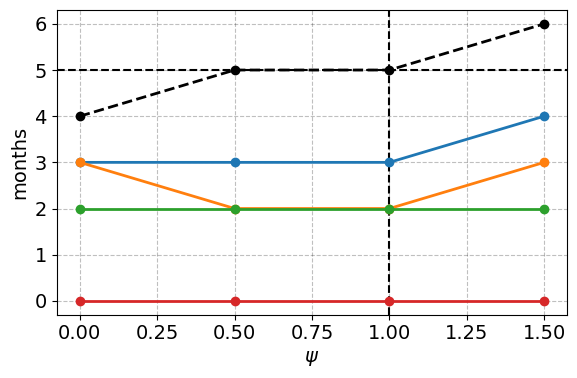

In [12]:
plot(model,models_psi_xi,psi_vec,xi_vec)